## init install

In [70]:
!pip install -r ../documents/requirements.txt

    100% |################################| 26.2MB 898kB/s eta 0:00:01    61% |###################             | 16.1MB 12.3MB/s eta 0:00:01    65% |#####################           | 17.3MB 10.2MB/s eta 0:00:01
    58% |##################              | 392.7MB 11.8MB/s eta 0:00:25 0% |                                | 2.4MB 11.2MB/s eta 0:01:01    0% |                                | 4.8MB 12.3MB/s eta 0:00:55    1% |                                | 13.4MB 10.9MB/s eta 0:01:02    2% |                                | 19.1MB 12.3MB/s eta 0:00:54    5% |#                               | 34.6MB 12.3MB/s eta 0:00:53    5% |#                               | 35.8MB 11.0MB/s eta 0:00:59    5% |#                               | 40.3MB 10.9MB/s eta 0:00:59    6% |#                               | 41.5MB 11.8MB/s eta 0:00:54    6% |##                              | 44.6MB 12.1MB/s eta 0:00:53    6% |##                              | 45.8MB 10.9MB/s eta 0:00:59    6% |##                       

    100% |################################| 3.3MB 6.1MB/s eta 0:00:01    44% |##############                  | 1.5MB 11.7MB/s eta 0:00:01    99% |############################### | 3.3MB 12.2MB/s eta 0:00:01
    100% |################################| 1.6MB 9.2MB/s eta 0:00:01    40% |#############                   | 655kB 12.3MB/s eta 0:00:01
    100% |################################| 4.4MB 6.2MB/s eta 0:00:01    58% |##################              | 2.5MB 11.7MB/s eta 0:00:01
    100% |################################| 1.3MB 7.6MB/s eta 0:00:01
  Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Found existing installation: protobuf 3.6.0
    Uninstalling protobuf-3.6.0:
      Successfully uninstalled protobuf-3.6.0
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## DL, unzip rotatedMNIST

In [11]:
!unzip "../../data/rotatedMNIST/mnist_rotation_new" -d "../../data/rotatedMNIST/mnist_rotation_new"

Archive:  ../../data/rotatedMNIST/mnist_rotation_new.zip
  inflating: ../../data/rotatedMNIST/mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat  
  inflating: ../../data/rotatedMNIST/mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat  


## Load MNIST

All the datasets are provided as zip archives. Each archive contains two files -- a training (and validation) set and a test set. We used the last 2000 examples of the training sets as validation sets and, in the case of SVMs, retrained the models with the entire set after choosing the optimal parameters on these validation sets. Data is stored at one example per row, the features being space-separated. There are 784 features per example (=28*28 images), corresponding to the first 784 columns of each row. The last column is the label, which is 0 to 9.

In [1]:
import numpy as np

In [2]:
def load_binarized_mnist_rot(path):
    # rotated
    train_x = np.loadtxt(path + "mnist_all_rotation_normalized_float_train_valid.amat")
    test_x = np.loadtxt(path + "mnist_all_rotation_normalized_float_test.amat")
    return train_x, test_x
def load_binarized_mnist(path):
    # mnist
    train_x = np.loadtxt(path + "mnist_train.amat")
    test_x = np.loadtxt(path + "mnist_test.amat")
    return train_x, test_x

In [3]:
train_x, test_x = load_binarized_mnist("../../data/MNIST/mnist/")
train_x_rot, test_x_rot = load_binarized_mnist_rot("../../data/rotatedMNIST/mnist_rotation_new/")

In [4]:
train_x.shape, type(train_x), test_x.shape

((12000, 785), numpy.ndarray, (50000, 785))

## About MNIST

In [5]:
import collections

In [6]:
import matplotlib.pyplot as plt

In [7]:
labels_train = [train_x[i, -1] for i in range(train_x.shape[0])]
labels_test = [test_x[i, -1] for i in range(train_x.shape[0])]

In [8]:
labels_train_rot = [train_x_rot[i, -1] for i in range(train_x_rot.shape[0])]
labels_test_rot = [test_x_rot[i, -1] for i in range(train_x_rot.shape[0])]

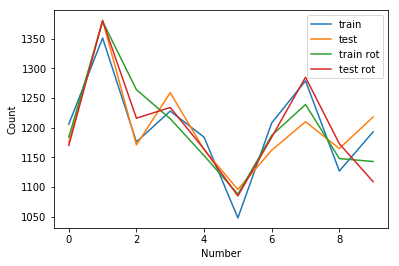

In [9]:
plt.plot(collections.Counter(labels_train).values(), label="train")
plt.plot(collections.Counter(labels_test).values(), label="test")

plt.plot(collections.Counter(labels_train_rot).values(), label="train rot")
plt.plot(collections.Counter(labels_test_rot).values(), label="test rot")

plt.ylabel("Count")
plt.xlabel("Number")
plt.legend()
plt.show()

-----

-----

# 以下から実行

## set args

In [10]:
import torch

In [11]:
from tensorboardX import SummaryWriter

class Args():
    gpu_id = 0
    epoch = 30
    num_pos = 1
    num_neg = 1
    zsize = 128
    batch_size = 1000
    max_len = 10000
    logdir = "mnist_margin01_data10k"
    shuffle = {"train":False, "test":False}
    loss_function_name = "TripletMargin"
    model_name = "test_mninst"
    device = torch.device("cuda:" + str(gpu_id) if torch.cuda.is_available() else "cpu")
    max_predict = 1
    margin = 0.1
    data_dir = "../../data/MNIST/mnist/"
#    data_dir = "../../data/rotatedMNIST/mnist_rotation_new/"

args = Args()
writer = SummaryWriter(log_dir="../log/tensorboard/" + args.logdir)


## define model

In [12]:
from models.worm2vec_non_sequential import Worm2vec_nonseq, Lossfunction
import torch.optim as optim
import config

In [13]:
# model
model = Worm2vec_nonseq(zsize=args.zsize)
model.weight_init(mean=0, std=0.02)

# optimizer
args.optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

# lossfunction
args.loss_function = Lossfunction(args.loss_function_name,
                             num_pos=args.num_pos,
                             num_neg=args.num_neg,
                             batchsize=args.batch_size,
                             tau=config.tau,
                             margin=args.margin)

In [14]:
model.to(args.device)

Worm2vec_nonseq(
  (enc): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padd

In [16]:
!pip install torchsummary

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
from torchsummary import summary
summary(model, [(1, 64, 64), (1, 64, 64), (1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1            [-1, 1, 32, 32]               0
            Conv2d-2            [-1, 8, 32, 32]              80
       BatchNorm2d-3            [-1, 8, 32, 32]              16
              ReLU-4            [-1, 8, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             584
       BatchNorm2d-6            [-1, 8, 32, 32]              16
              ReLU-7            [-1, 8, 32, 32]               0
         MaxPool2d-8            [-1, 8, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]           1,168
      BatchNorm2d-10           [-1, 16, 16, 16]              32
             ReLU-11           [-1, 16, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           2,320
      BatchNorm2d-13           [-1, 16, 16, 16]              32
             ReLU-14           [-1, 16,

## define loader 

In [6]:
from features.rot_mnist_dataset import RotMnistDataset
from torchvision import transforms
from features.worm_transform import Resize_nonbinary, Normalize

In [7]:
def get_loader():
    """
    Return:
        train_loader
        test_loader
    """
    mnist_transforms = transforms.Compose([
        Normalize(max_value=255),
        Resize_nonbinary((config.IMG_SIZE, config.IMG_SIZE)),
        Normalize(max_value=1)]
    )

    train_dataset = RotMnistDataset(root=args.data_dir,
                                train=True,
                                num_pos=args.num_pos,
                                num_neg=args.num_neg,
                                batch_size=args.batch_size,
                                max_len=args.max_len,
                                transform=mnist_transforms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=args.shuffle["train"])
    
    test_dataset = RotMnistDataset(root=args.data_dir,
                                train=False,
                                num_pos=args.num_pos,
                                num_neg=args.num_neg,
                                batch_size=args.batch_size,
                                max_len=args.max_len,
                                transform=mnist_transforms)

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.batch_size, shuffle=args.shuffle["test"])

    return train_loader, test_loader

In [8]:
train_loader, test_loader = get_loader()

## test image plot

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

0 torch.Size([1000, 1, 1, 64, 64]) torch.Size([1000, 1, 1, 64, 64]) torch.Size([1000, 1, 1, 64, 64])


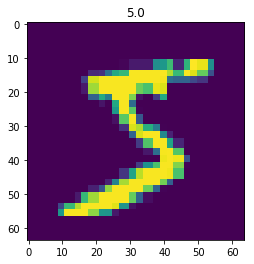

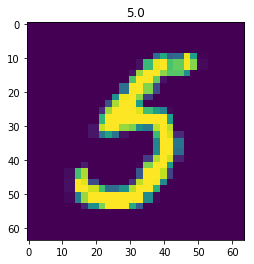

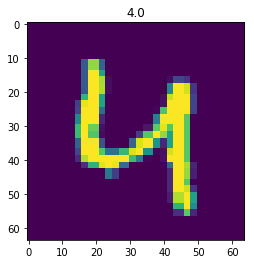

In [10]:
# mnist
for i, (a, p, n, labels) in enumerate(train_loader):
    print(i, a.shape, p.shape, n.shape)
    plt.imshow(np.asarray(a[0, 0, 0]))
    plt.title(labels[0][0])
    plt.show()
    plt.imshow(np.asarray(p[0, 0, 0]))
    plt.title(labels[1][0])
    plt.show()
    plt.imshow(np.asarray(n[0, 0, 0]))
    plt.title(labels[2][0])
    plt.show()
    break

0 torch.Size([1, 1, 1, 64, 64]) torch.Size([1, 3, 1, 64, 64]) torch.Size([1, 9, 1, 64, 64])


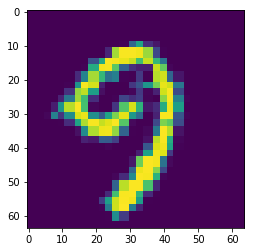

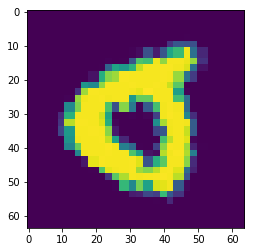

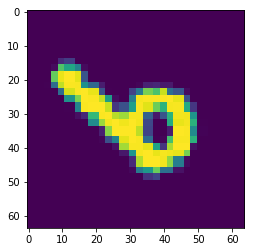

In [11]:
# rotated
for i, (a, p, n) in enumerate(train_loader):
    print(i, a.shape, p.shape, n.shape)
    plt.imshow(np.asarray(a[0, 0, 0]))
    plt.show()
    plt.imshow(np.asarray(p[0, 0, 0]))
    plt.show()
    plt.imshow(np.asarray(n[0, 0, 0]))
    plt.show()
    break

---

## train

In [11]:
from trainer import Trainer

In [12]:
trainer = Trainer(model,
                  args.optimizer,
                  writer,
                  args.device,
                  args.epoch,
                  args.gpu_id,
                  args.loss_function)

In [13]:
trainer.fit(train_loader=train_loader, test_loader=test_loader)

[2020-07-08 03:45:40,410] - [trainer] - [INFO] - Epoch: 1/30 GPU: 0
[2020-07-08 03:47:24,071] - [trainer] - [INFO] - Epoch: 2/30 GPU: 0
[2020-07-08 03:49:01,458] - [trainer] - [INFO] - Epoch: 3/30 GPU: 0
[2020-07-08 03:50:42,137] - [trainer] - [INFO] - Epoch: 4/30 GPU: 0
[2020-07-08 03:52:23,367] - [trainer] - [INFO] - Epoch: 5/30 GPU: 0
[2020-07-08 03:54:14,978] - [trainer] - [INFO] - Epoch: 6/30 GPU: 0
[2020-07-08 03:56:04,823] - [trainer] - [INFO] - Epoch: 7/30 GPU: 0
[2020-07-08 03:57:51,188] - [trainer] - [INFO] - Epoch: 8/30 GPU: 0
[2020-07-08 03:59:38,024] - [trainer] - [INFO] - Epoch: 9/30 GPU: 0
[2020-07-08 04:01:27,028] - [trainer] - [INFO] - Epoch: 10/30 GPU: 0
[2020-07-08 04:03:12,552] - [trainer] - [INFO] - Epoch: 11/30 GPU: 0
[2020-07-08 04:05:01,290] - [trainer] - [INFO] - Epoch: 12/30 GPU: 0
[2020-07-08 04:06:47,480] - [trainer] - [INFO] - Epoch: 13/30 GPU: 0
[2020-07-08 04:08:33,613] - [trainer] - [INFO] - Epoch: 14/30 GPU: 0
[2020-07-08 04:10:21,625] - [trainer] - [IN

## save model

In [14]:
writer.close()

In [15]:
# Save model
torch.save(model.state_dict(), "../models/" + args.model_name + ".pkl")

#logger.info("End train")


---

## embed

In [9]:
# ここから実行する場合
model.load_state_dict(torch.load("../models/" + args.model_name + ".pkl"))
model.to(args.device)

Worm2vec_nonseq(
  (enc): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padd

In [16]:
from predictor import Predictor

In [17]:
args.logdir = "predict_" + args.logdir
writer = SummaryWriter(log_dir="../log/tensorboard/" + args.logdir)

In [18]:
predictor = Predictor(model, 
                     writer,
                     args.device,
                     args.gpu_id,
                     args.max_predict
                     )

In [19]:
predictor.predict(test_loader=test_loader)

In [20]:
writer.close()